In [ ]:
## Author : Shubham Bindal ##

'''
In the below approach, instead of compressing and reconstructing the same image, 
I have used denoising encoder-decoder to learn a bit more about the images to
extract better features from model.
'''

'\nIn the below approach, instead of compressing and reconstructing the same image, \nI have used denoising encoder-decoder to learn a bit more about the images to\nextract better features from model.\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
## unzip Dataset to /content dir ##

!unzip '/content/drive/My Drive/Avantari/dataset.zip'

Archive:  /content/drive/My Drive/Avantari/dataset.zip
   creating: dataset/
  inflating: dataset/3604.jpg        
  inflating: dataset/3487.jpg        
  inflating: dataset/2902.jpg        
  inflating: dataset/1484.jpg        
  inflating: dataset/1175.jpg        
  inflating: dataset/246.jpg         
  inflating: dataset/3618.jpg        
  inflating: dataset/3763.jpg        
  inflating: dataset/2436.jpg        
  inflating: dataset/3248.jpg        
  inflating: dataset/1662.jpg        
  inflating: dataset/4282.jpg        
  inflating: dataset/2351.jpg        
  inflating: dataset/4385.jpg        
  inflating: dataset/2380.jpg        
  inflating: dataset/4651.jpg        
  inflating: dataset/2830.jpg        
  inflating: dataset/1846.jpg        
  inflating: dataset/1807.jpg        
  inflating: dataset/1536.jpg        
  inflating: dataset/2977.jpg        
  inflating: dataset/120.jpg         
  inflating: dataset/1103.jpg        
  inflating: dataset/1985.jpg        
  inflating

In [ ]:
## Importing required libraries for building the encoder-decoder network##

from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import Activation, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
class ConvAutoencoder:
  @staticmethod
  def build(width, height, depth, filters=(32, 32, 64, 64, 128, 128), latentDim=512):
    '''
    This function will create the encoder-decoder network
    
    parameters : 
      width : width of input images
      height : width of input images
      depth : width of input images
      filters : number of filters which will be applied on the convolution layers respectively
      latentDim : dimension of bottleneck feature vector

    return : 
      autoencoder : the encoder-decoder (autoencoder) network
    '''

    inputShape = (height, width, depth)
    chanDim = -1
		# define the input to the encoder
    inputs = Input(shape=inputShape)
    x = inputs
		# loop over the number of filters
    for f in filters:
      x = Conv2D(f, (3,3), strides=2, padding='same')(x)
      x = LeakyReLU(alpha= 0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)

    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim, name="encoded")(x)

    # start building the decoder model which will accept the
		# output of the encoder as its inputs
    x = Dense(np.prod(volumeSize[1:]))(latent)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
    for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
      x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid", name="decoded")(x)
		# construct our autoencoder model
    autoencoder = Model(inputs, outputs, name="autoencoder")
		
    # return the autoencoder model
    return autoencoder






In [ ]:
import os
import cv2
import numpy as np

from utils import get_preprocessed_images

def add_salt_pepper_noise(X_imgs):

    '''
    This function will add salt and pepper noise to given images

    parameters:
      X_imgs : numpy array of images, to which noise is added; dimension --> (number of images, height, width, channels)

    return:
      X_imgs_copy : numpy array of noisy images; dimension --> (number of images, height, width, channels)

    '''

    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy
  


In [ ]:
import random

img_dir_path = '/content/dataset'
img_list = os.listdir(img_dir_path)

# Splitting dataset into train and validation data 

# training data contain 4500 images 
train_list = random.sample(img_list, 4500)

# validation data contain (total number of images) - 4500 (i.e number of training images) 
validation_list = list(set(img_list)-set(train_list))

# Get preprocessed original train data 
orig_train = get_preprocessed_images(img_dir_path, train_list)
print(orig_train.shape)

# Get noisy train data 
noisy_train = add_salt_pepper_noise(orig_train)
print(noisy_train.shape)

# Get preprocessed original validation data 
orig_validation = get_preprocessed_images(img_dir_path, validation_list)
print(orig_validation.shape)

# Get noisy validation data 
noisy_validation = add_salt_pepper_noise(orig_validation)
print(noisy_validation.shape)


(4500, 256, 256, 3)
(4500, 256, 256, 3)
(238, 256, 256, 3)
(238, 256, 256, 3)


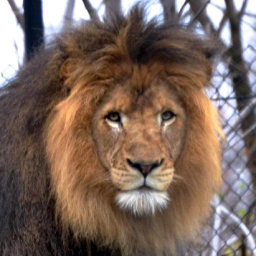

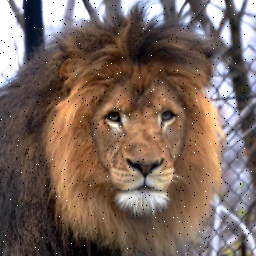

In [ ]:
## Visulaing a original image and its noisy one ##

from google.colab.patches import cv2_imshow

cv2_imshow(orig_train[0]*255)
cv2_imshow(noisy_train[0]*255)

In [ ]:
# Training the encoder-decoder #

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Maximum number of epochs
EPOCHS = 100

# Learning rate
INIT_LR = 1e-3

# Batch size
BS = 16

# Creating a callback for earlystopping, the training will stop if the validation loss doesn't decrease in last 10 epochs by >= 1e-5
earlystopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, mode='min', restore_best_weights=True)

# Create a autoencoder network
autoencoder = ConvAutoencoder.build(256, 256, 3)

# Using Adam optimizer 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# Compiling the network, with mean squared error loss
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(noisy_train, orig_train, validation_data=(noisy_validation, orig_validation), epochs=EPOCHS, batch_size=BS, callbacks= [earlystopping])

Epoch 1/100
282/282 [==============================] - 17s 60ms/step - loss: 0.0339 - val_loss: 0.0345
Epoch 2/100
282/282 [==============================] - 16s 58ms/step - loss: 0.0221 - val_loss: 0.0202
Epoch 3/100
282/282 [==============================] - 16s 58ms/step - loss: 0.0200 - val_loss: 0.0232
Epoch 4/100
282/282 [==============================] - 16s 58ms/step - loss: 0.0188 - val_loss: 0.0177
Epoch 5/100
282/282 [==============================] - 16s 57ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 6/100
282/282 [==============================] - 16s 57ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 7/100
282/282 [==============================] - 16s 58ms/step - loss: 0.0152 - val_loss: 0.0169
Epoch 8/100
282/282 [==============================] - 16s 58ms/step - loss: 0.0148 - val_loss: 0.0154
Epoch 9/100
282/282 [==============================] - 16s 57ms/step - loss: 0.0144 - val_loss: 0.0165
Epoch 10/100
282/282 [==============================] - 16s 57ms/step - l

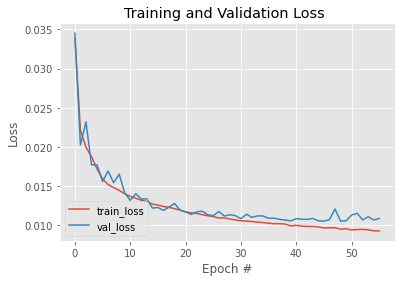

In [ ]:
# construct a plot of loss

import matplotlib.pyplot as plt
%matplotlib inline

epoch_with_lowest_val_loss = 56  # Noticed from above  

N = np.arange(0, epoch_with_lowest_val_loss)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


In [ ]:
# Save the model

autoencoder.save('/content/drive/My Drive/Avantari/model_salt_and_pepper', save_format="h5")